# **Predictive Analytics**

- Import Library

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

- Load Data

In [3]:
df = pd.read_csv('../data/raw/SolarPrediction.csv', parse_dates=['Time'])

C:\Users\acer\AppData\Local\Temp\ipykernel_12496\2920403303.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('../data/raw/SolarPrediction.csv', parse_dates=['Time'])


## Exploration Data Analysis

In [4]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,2025-05-25 23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,2025-05-25 23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,2025-05-25 23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,2025-05-25 23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,2025-05-25 23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [5]:
df.dtypes

UNIXTime                           int64
Data                              object
Time                      datetime64[ns]
Radiation                        float64
Temperature                        int64
Pressure                         float64
Humidity                           int64
WindDirection(Degrees)           float64
Speed                            float64
TimeSunRise                       object
TimeSunSet                        object
dtype: object

In [7]:
df.isna().sum()

UNIXTime                  0
Data                      0
Time                      0
Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
TimeSunRise               0
TimeSunSet                0
dtype: int64

In [6]:
df.describe()

,UNIXTime,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
count,3.268600e+04,32686,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,1.478047e+09,2025-05-25 12:01:17.574068480,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869
min,1.472724e+09,2025-05-25 00:00:01,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000
25%,1.475546e+09,2025-05-25 06:00:17,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000
50%,1.478026e+09,2025-05-25 12:00:30,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000
75%,1.480480e+09,2025-05-25 18:00:49,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000
max,1.483265e+09,2025-05-25 23:56:25,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000
std,3.005037e+06,NaN,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474


In [8]:
df.duplicated().sum()

np.int64(0)

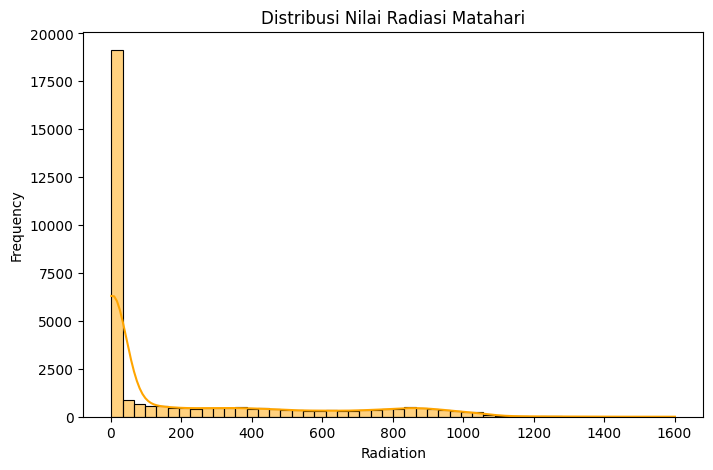

In [9]:
plt.figure(figsize=(8,5))
sns.histplot(df['Radiation'], kde=True, bins=50, color='orange')
plt.title('Distribusi Nilai Radiasi Matahari')
plt.xlabel('Radiation')
plt.ylabel('Frequency')
plt.show()

In [10]:
numerical_cols = ['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed']
correlation_matrix = df[numerical_cols].corr()

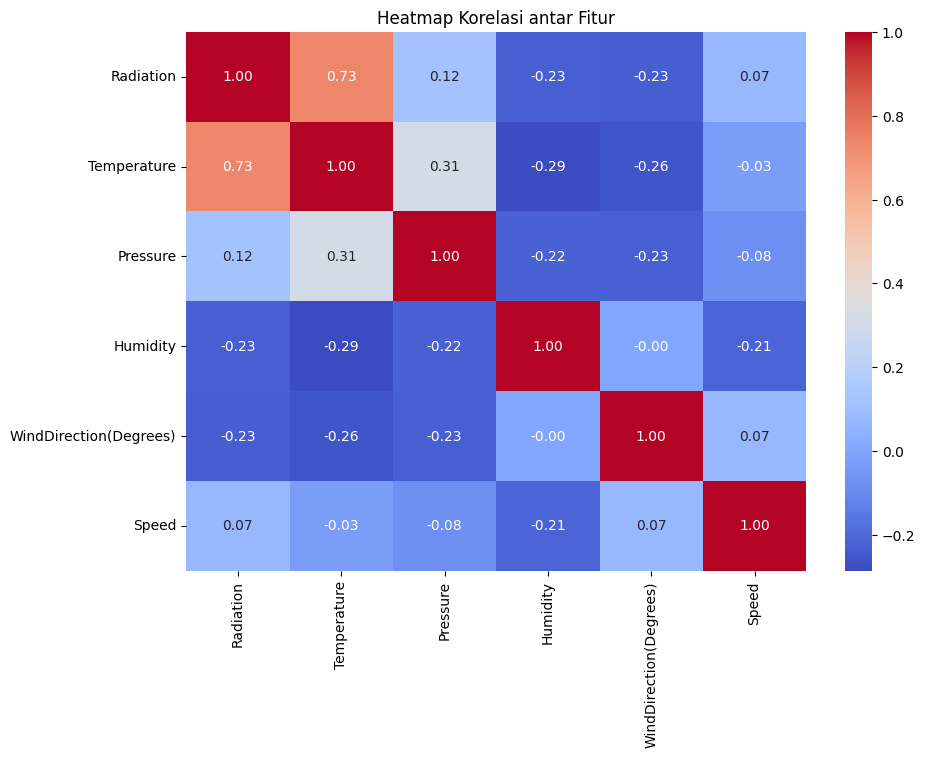

In [11]:
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap Korelasi antar Fitur')
plt.show()

## Data Preprocessing

In [12]:
def time_to_minutes(t):
    return t.hour * 60 + t.minute + t.second / 60
df['Temperature'] = df['Temperature'].astype(float)
df['Humidity'] = df['Humidity'].astype(float)
df['TimeSunRise'] = pd.to_datetime(df['TimeSunRise'], format="%H:%M:%S").dt.time
df['TimeSunSet'] = pd.to_datetime(df['TimeSunSet'], format="%H:%M:%S").dt.time
df['SunRiseMinutes'] = df['TimeSunRise'].apply(time_to_minutes)
df['SunSetMinutes'] = df['TimeSunSet'].apply(time_to_minutes)
df['CurrentMinutes'] = df['Time'].apply(time_to_minutes)
df['MinutesSinceSunrise'] = df['CurrentMinutes'] - df['SunRiseMinutes']
df['MinutesUntilSunset'] = df['SunSetMinutes'] - df['CurrentMinutes']
df['DaylightDuration'] = df['SunSetMinutes'] - df['SunRiseMinutes']
df = df.drop(columns=['UNIXTime','Data','Time','TimeSunRise','TimeSunSet'])

In [13]:
numeric =  df.select_dtypes(include="number").columns
for i in numeric:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outlier = df[(df[i] < lower) | (df[i] > upper)]
    print(f"Kolom {i} : {len(outlier)} outlier")

Kolom Radiation : 1965 outlier
Kolom Temperature : 89 outlier
Kolom Pressure : 1662 outlier
Kolom Humidity : 0 outlier
Kolom WindDirection(Degrees) : 1618 outlier
Kolom Speed : 479 outlier
Kolom SunRiseMinutes : 0 outlier
Kolom SunSetMinutes : 0 outlier
Kolom CurrentMinutes : 0 outlier
Kolom MinutesSinceSunrise : 0 outlier
Kolom MinutesUntilSunset : 0 outlier
Kolom DaylightDuration : 0 outlier


In [14]:
def outlierhandling(series):
    Q1 = df[series].quantile(0.25)
    Q3 = df[series].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df.loc[df[series] > upper, series] = upper
    df.loc[df[series] < lower, series] = lower
    return df
for i in numeric:
    df = outlierhandling(i)
for i in numeric:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outlier = df[(df[i] < lower) | (df[i] > upper)]
    print(f"Kolom {i} : {len(outlier)} outlier")

Kolom Radiation : 0 outlier
Kolom Temperature : 0 outlier
Kolom Pressure : 0 outlier
Kolom Humidity : 0 outlier
Kolom WindDirection(Degrees) : 0 outlier
Kolom Speed : 0 outlier
Kolom SunRiseMinutes : 0 outlier
Kolom SunSetMinutes : 0 outlier
Kolom CurrentMinutes : 0 outlier
Kolom MinutesSinceSunrise : 0 outlier
Kolom MinutesUntilSunset : 0 outlier
Kolom DaylightDuration : 0 outlier


In [15]:
X = df.drop('Radiation',axis=1)
y = df['Radiation']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Modelling

In [16]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(1)
])
model.compile(optimizer='Adam', loss='mse', metrics=['mae'])
model.summary()

d:\Dicoding\Predictive-Analytic\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,937 (687.25 KB)

 Trainable params: 175,937 (687.25 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
callback = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6,verbose=1),
    ModelCheckpoint(filepath='../models/best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
]

In [18]:
history = model.fit(X_train_scaled,y_train, validation_split=0.2, batch_size=64, epochs=100, callbacks=[callback])

Epoch 1/100
317/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 66210.3984 - mae: 163.4243
Epoch 1: val_loss improved from inf to 16328.24121, saving model to ../models/best_model.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 65218.2930 - mae: 161.8263 - val_loss: 16328.2412 - val_mae: 67.5570 - learning_rate: 0.0010
Epoch 2/100
321/327 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14329.5654 - mae: 63.7946
Epoch 2: val_loss improved from 16328.24121 to 11213.68164, saving model to ../models/best_model.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 14310.9639 - mae: 63.7391 - val_loss: 11213.6816 - val_mae: 55.5730 - learning_rate: 0.0010
Epoch 3/100
312/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11266.6953 - mae: 54.8700
Epoch 3: val_loss improved from 11213.68164 to 10016.27539, saving model to ../models/best_model.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 11239.3877 - mae: 54.7944 - val_loss: 10016.2754 - val_mae: 50.2949 - learning_rate: 0.0010
Epoch 4/100
3

## Evaluation

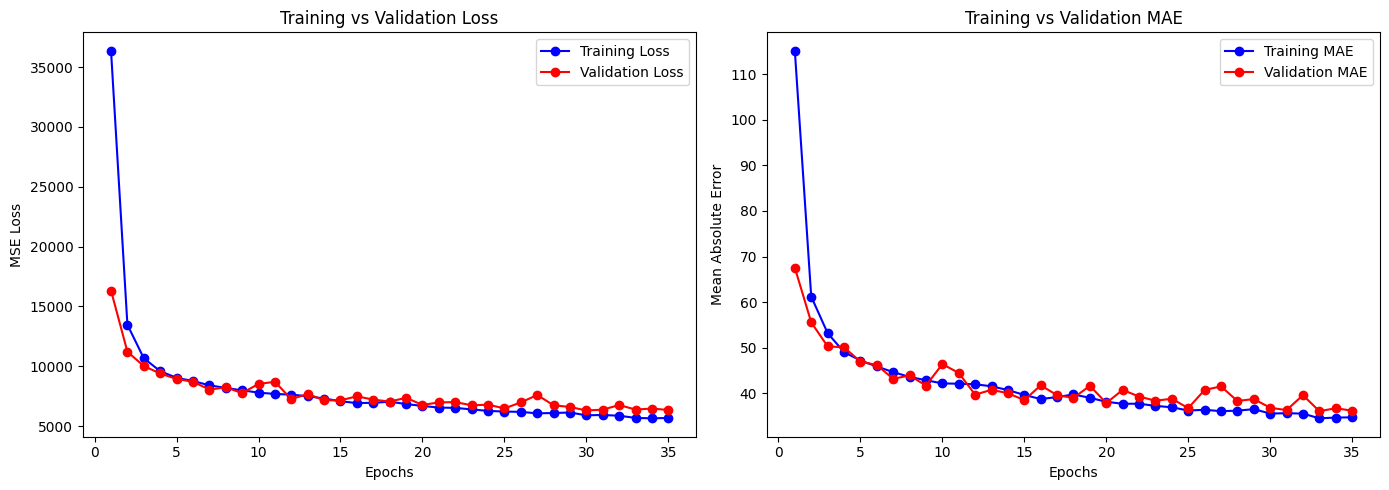

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(loss) + 1)

# Plot Loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(epochs, mae, 'bo-', label='Training MAE')
plt.plot(epochs, val_mae, 'ro-', label='Validation MAE')
plt.title('Training vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
val_mae = history.history['val_mae'][-1]
mae_percent = (val_mae / y_test.mean()) * 100
print(f"MAE sekitar {mae_percent:.2f}% dari rata-rata radiation")

MAE sekitar 18.32% dari rata-rata radiation
